In [2]:
from functools import partial
from pathlib import Path

from skfem import *
import skfem as fem
from skfem.models.poisson import laplace, mass, unit_load
from skfem.io.json import from_file

import numpy as np
from scipy.sparse.linalg import inv, cg
import matplotlib.pyplot as plt
from skfem.visuals.matplotlib import plot
import jax
import jax.numpy as jnp
from jax.experimental import sparse
import time

In [3]:
times = [] # To keep track of time it took for every task

In [4]:
print(jax.devices())
print(jax.default_backend())

[cuda(id=0)]
gpu


## Define Mesh

Can be done on same mesh as problem you are solving

DOFs: 81 | Interior: 49


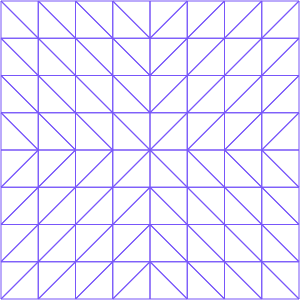

In [8]:
L = 5.0
mesh = MeshTri.init_sqsymmetric().refined(2)
# mesh = fem.Mesh.load("../2D/thismesh.msh")

mesh = mesh.scaled(2 * L).translated((-L, -L))
element = ElementTriP1()
basis = Basis(mesh,element)
source = np.array([1, 1])
interior_dofs = np.setdiff1d(np.arange(basis.N), basis.get_dofs().flatten())
print(f"DOFs: {basis.N} | Interior: {len(interior_dofs)}")
mesh

## Simply analytics to compare to

In [9]:
def greens(a: float, s: np.ndarray, x: np.ndarray) -> np.ndarray:
    """Return the Green's function for a disk of radius `a`

    with source at point `s`, evaluated at points `x`.
    """

    snorm = np.linalg.norm(s)
    sfull = s[:, None, None]
    numerator = np.linalg.norm(snorm ** 2 * x - a ** 2 * sfull, axis=0)
    denominator = a * snorm * np.linalg.norm(x - sfull, axis=0)
    return np.log(numerator / denominator) / 2 / np.pi

Analytical Expression for Green's Func of $-\nabla^2$ is: $-\frac{1}{2\pi} ln(r)$, exactly the kernel, and exactly what this solves for

Use three methods to solve for $A^{-1}b$, on the interior, which is what we want ($G = A^{-1}$, the kernel, and $b$ is just any vector we multiply):

1) Using scikit-FEM's built-in solve(A,b) (As a control, since is not JAX compatible)
2) Directly computing $A^{-1}$ (simple but expensive) - JAX Compatible
3) Using an advanced Conjugate Gradient method (good for GPUs of very large meshes) - JAX Compatible

In [ ]:
# Bilinear form, as a matrix wrt basis elements. Namely a(e_i,e_j) = \int grad(e_i) grad(e_j), so specifically weak form for negative laplacian
t1 = time.perf_counter()

A = asm(laplace, basis)

D = basis.get_dofs()

# Define b: 
source = np.array([1,1])
b = basis.point_source(source)

# Apply BCs
A_int, b_int,_ , _ = condense(A, b, D=D, expand=True)

def scipy_to_jax_sparse(A_scipy):
    # Ensure it's in COO format first (simplest intermediate format)
    A_coo = A_scipy.tocoo()
    indices = jnp.array(np.vstack((A_coo.row, A_coo.col)).T)
    data = jnp.array(A_coo.data)
    
    # Create the JAX BCOO matrix
    return sparse.BCOO((data, indices), shape=A_scipy.shape)
A_int_jax, b_int_jax = scipy_to_jax_sparse(A_int),jnp.array(b_int)

# Three methods for solving A^-1b
t2 = time.perf_counter()
print(f"Preprocessing Took: {t2-t1}")

# Method 1: solve(A,b) in scikit-FEM
u1 = solve(A_int,b_int)
t3 = time.perf_counter()

print(f"Method 1 Done: | Took: {t3-t2}")
# Method 2: Just compute A^-1
dense_mat = A_int_jax.todense()
print(dense_mat)

A_int_inv = jax.scipy.linalg.inv(dense_mat)
u2 = A_int_inv @ b_int
t4 = time.perf_counter()

print(f"Method 2 Done | Took: {t4 - t3}")
# Method 3: CG Approach
u3,info = jax.scipy.sparse.linalg.cg(A_int_jax,b_int_jax)
t5 = time.perf_counter()

print(f"Method 3 Done | Took {t5-t4}")

times.append([basis.N,t2-t1,t3-t2,t4-t3,t5-t4]) # [dofs,preprossing,method 1, method 2, method 3]

Preprocessing Took: 0.04025187200750224
Method 1 Done: | Took: 0.0008334860031027347
[[ 4.  0.  0. ...  0.  0.  0.]
 [ 0.  4.  0. ...  0.  0.  0.]
 [ 0.  0.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4.  0. -1.]
 [ 0.  0.  0. ...  0.  4.  0.]
 [ 0.  0.  0. ... -1.  0.  4.]]
Method 2 Done | Took: 0.2674775540072005
Method 3 Done | Took 0.36934909198316745


: 

# Compute Accuracy of Three Methods

In [22]:
a = np.linalg.norm(basis.mesh.p, axis=0).max()
exact = basis.project(lambda x: greens(a, source, x))
exact_int = exact[interior_dofs]
print(len(exact_int))

# Method 1 Error
error1 = u1 - exact_int
l2error1 = np.sum(error1**2)

# Method 2 Error
error2 = u2 - exact_int
l2error2 = jnp.sum(error2**2)

# Method 3 Error
error3 = u3 - exact_int
l2error3 = jnp.sum(error3**2)

print(f"Method 1 Error: {l2error1}")
print(f"Method 2 Error: {l2error2}")
print(f"Method 3 Error: {l2error3}")

49
Method 1 Error: 0.1096915269268795
Method 2 Error: 0.10969152301549911
Method 3 Error: 0.1096915453672409


In [ ]:
# Linear form, as a vector wrt to basis elements (point source)
# sources = basis.doflocs.T
# for source in sources:
#     b = basis.point_source(source)
#     num_zeros = np.count_nonzero(b == 0)
#     num_ones = np.count_nonzero(b == 1)

#     nonzero_indices = np.nonzero(b)

#     print(f"Len: {len(b)}, Zeroes: {num_zeros}, Ones: {num_ones} | First nonzero index: {nonzero_indices[0]}")


# condensed = condense(A, b, D=basis.get_dofs()) # a 4 tuple, containing A and b without the boundary dofs (applying bcs)
# x = solve(*condensed) # Destructure arguments

# print(b)

In [26]:
print(times)

[8.10000000e+01 2.70695798e-03 4.00375109e-04 1.01824990e-03
 9.76039590e-02 2.89000000e+02 4.86565419e-02 7.54458131e-04
 2.05385958e-01 1.86726917e-01]


<Axes: >

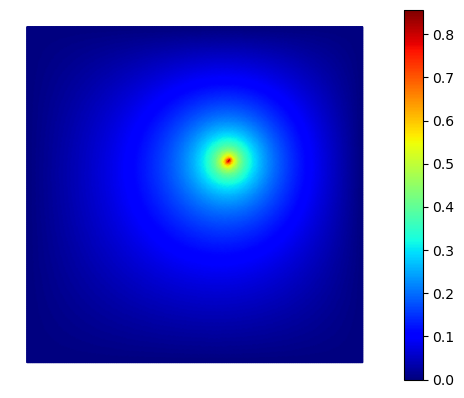

In [25]:
def visualize(u_interior):
    u_full = np.zeros(len(basis.doflocs.T))
    interior_dofs = np.setdiff1d(np.arange(basis.N), basis.get_dofs().flatten())
    u_full[interior_dofs] = u_interior
    return plot(basis,
                u_full,
                shading='gouraud',
                nrefs=2,
                colorbar=True)

visualize(u1)

<Axes: >

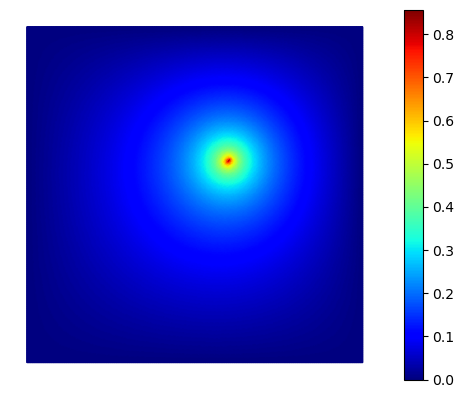

In [26]:
visualize(u2)

<Axes: >

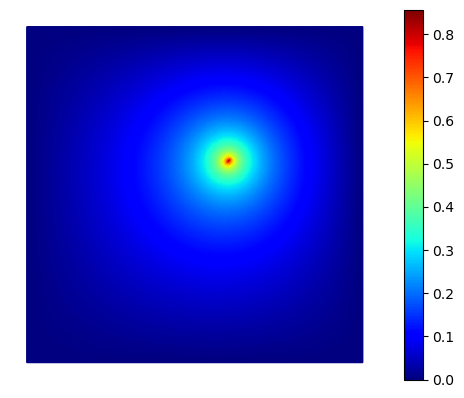

In [27]:
visualize(u3)

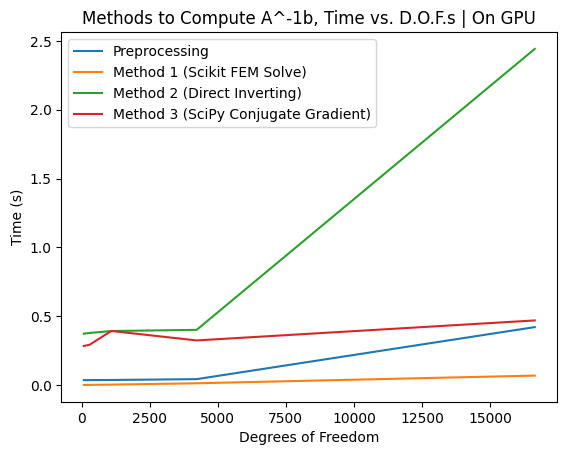

In [23]:
npTimes = np.array(times)
plt.plot(npTimes[:,0],npTimes[:,1],label="Preprocessing")
plt.plot(npTimes[:,0],npTimes[:,2],label="Method 1 (Scikit FEM Solve)")
plt.plot(npTimes[:,0],npTimes[:,3],label="Method 2 (Direct Inverting)")
plt.plot(npTimes[:,0],npTimes[:,4],label="Method 3 (SciPy Conjugate Gradient)")
plt.title("Methods to Compute A^-1b, Time vs. D.O.F.s | On GPU")
plt.xlabel("Degrees of Freedom")
plt.ylabel("Time (s)")
plt.legend()